<a href="https://colab.research.google.com/github/CubatLin/AmpliGraph/blob/master/tutorial/colab/Knowledge_Graph(Ampligraph)_origin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import math
import pprint
import csv

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import seaborn as sns

from collections import defaultdict, deque
from datetime import datetime, timedelta
from tqdm import tqdm
# from sklearn.utils import shuffle

In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [3]:
import tensorflow as tf 

print('TensorFlow  version: {}'.format(tf.__version__))

# Get the GPU name
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

TensorFlow  version: 1.15.2
Found GPU at: /device:GPU:0


In [4]:
%%capture 
# Install AmpliGraph library
! pip install ampligraph

# Required to visualize embeddings with tensorboard projector, comment out if not required!
! pip install --user tensorboard

# Required to plot text on embedding clusters, comment out if not required!
! pip install --user git+https://github.com/Phlya/adjustText

# Prepare Data
* 三元組： Entity1 -> Relation -> Entity2

In [5]:
# Raw Data
data = [
    ['accountID1','buy','productID1'],
    ['accountID1','buy','productID2'],
    ['accountID1','buy','productID3'],
    ['accountID1','buy','productID4'],
    ['accountID1','buy','productID5'],
    ['accountID2','buy','productID1'],
    ['accountID2','buy','productID2'],
    ['accountID2','buy','productID3'],
    ['accountID3','buy','productID3'],
    ['accountID3','buy','productID4'],
    ['accountID3','buy','productID5'],
    ['productID1','category','cloth'],
    ['productID2','category','Pants'],
    ['productID3','category','coat'],
    ['productID4','category','ring'],
    ['productID5','category','hat'],
    ['productID6','category','cloth'],    # productID6是新商品
  ]
print(data[:3])

[['accountID1', 'buy', 'productID1'], ['accountID1', 'buy', 'productID2'], ['accountID1', 'buy', 'productID3']]


## 建構圖譜 - 由頂至下


In [6]:
kg_graph = defaultdict(lambda: defaultdict(set))
for data_ in tqdm(data):
    if data_[1] == 'buy':
        kg_graph['root']['account'].add(data_[0])
    kg_graph[str(data_[0])][str(data_[1])].add(str(data_[2]))

kg_graph

100%|██████████| 17/17 [00:00<00:00, 87167.69it/s]


defaultdict(<function __main__.<lambda>>,
            {'accountID1': defaultdict(set,
                         {'buy': {'productID1',
                           'productID2',
                           'productID3',
                           'productID4',
                           'productID5'}}),
             'accountID2': defaultdict(set,
                         {'buy': {'productID1', 'productID2', 'productID3'}}),
             'accountID3': defaultdict(set,
                         {'buy': {'productID3', 'productID4', 'productID5'}}),
             'productID1': defaultdict(set, {'category': {'cloth'}}),
             'productID2': defaultdict(set, {'category': {'Pants'}}),
             'productID3': defaultdict(set, {'category': {'coat'}}),
             'productID4': defaultdict(set, {'category': {'ring'}}),
             'productID5': defaultdict(set, {'category': {'hat'}}),
             'productID6': defaultdict(set, {'category': {'cloth'}}),
             'root': defaultdict(set,

In [8]:
# 將new product補指
# Structure: kg_graph[Entity1][Relation].add(Entity2)

# 新增一個虛擬節點Admin
kg_graph['root']['account'].add('ADMIN')

# 用Admin指向新商品
kg_graph['ADMIN']['require'].add('productID6')


kg_graph

defaultdict(<function __main__.<lambda>>,
            {'ADMIN': defaultdict(set, {'require': {'productID6'}}),
             'accountID1': defaultdict(set,
                         {'buy': {'productID1',
                           'productID2',
                           'productID3',
                           'productID4',
                           'productID5'}}),
             'accountID2': defaultdict(set,
                         {'buy': {'productID1', 'productID2', 'productID3'}}),
             'accountID3': defaultdict(set,
                         {'buy': {'productID3', 'productID4', 'productID5'}}),
             'productID1': defaultdict(set, {'category': {'cloth'}}),
             'productID2': defaultdict(set, {'category': {'Pants'}}),
             'productID3': defaultdict(set, {'category': {'coat'}}),
             'productID4': defaultdict(set, {'category': {'ring'}}),
             'productID5': defaultdict(set, {'category': {'hat'}}),
             'productID6': defaultdict

In [10]:
# 基於路徑的推理
for id_ in tqdm(kg_graph['root']['account']):
    for product_ in kg_graph[id_]['buy']:
        for category_ in kg_graph[product_]['category']:
            kg_graph[id_]['require'].add(category_)

kg_graph['accountID1']

100%|██████████| 4/4 [00:00<00:00, 34663.67it/s]


defaultdict(set,
            {'buy': {'productID1',
              'productID2',
              'productID3',
              'productID4',
              'productID5'},
             'require': {'Pants', 'cloth', 'coat', 'hat', 'ring'}})

In [11]:
# ‎Breadth-First Search write file
with open(f"./kg_data.csv", 'w', encoding='utf-8', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=['Entity1', 'Relation', 'Entity2'])
    writer.writeheader()

    traversal = set()
    RDF = deque()
    RDF.append('root')
    while len(RDF) != 0:
        Entity1 = RDF.popleft()
        for Relation in kg_graph[Entity1].keys():
            for Entity2 in kg_graph[Entity1][Relation]:
                if (Entity1, Relation, Entity2) in traversal: continue
                traversal.add((Entity1, Relation, Entity2))
                RDF.append(Entity2)
                writer.writerow({
                    'Entity1': Entity1,
                    'Relation': Relation,
                    'Entity2': Entity2
                })

# Knowledge Graph Model

In [12]:
import tensorflow as tf
import ampligraph
from ampligraph.evaluation import train_test_split_no_unseen, evaluate_performance, mr_score, mrr_score, hits_at_n_score
from ampligraph.latent_features import TransE, ComplEx, HolE, DistMult, ConvE, ConvKB
from ampligraph.utils import save_model, restore_model
from sklearn.utils import shuffle

print('Ampligraph version: {}'.format(ampligraph.__version__))

Ampligraph version: 1.4.0


In [14]:
kg_data = pd.read_csv('./kg_data.csv')
kg_data

,Entity1,Relation,Entity2
0,root,account,accountID3
1,root,account,ADMIN
2,root,account,accountID2
3,root,account,accountID1
4,accountID3,buy,productID3
5,accountID3,buy,productID5
6,accountID3,buy,productID4
7,accountID3,require,ring
8,accountID3,require,hat
9,accountID3,require,coat


In [15]:
# KG model training
model = ComplEx(
            batches_count=2, seed=17, epochs=100, k=50, eta=2,
            loss='multiclass_nll', loss_params={'margin': 1},
            optimizer = 'sgd', optimizer_params = {'lr': 3e-2, 'end_lr': 5e-5, 'decay_cycle': 30, 'decay_lr_rate': 1.5},
            regularizer = 'LP', regularizer_params={'p': 3, 'lambda':0.01},
            verbose = True
        )

model.fit(kg_data.to_numpy())

save_model(model, 'ComplEx.pkl')

Average ComplEx Loss:   0.487536: 100%|██████████| 100/100 [00:01<00:00, 72.00epoch/s]


### Predict

In [16]:
# 人的需求分數
person_category_triples = [ 
      ['accountID2' for _ in range(5)],
      ['require' for _ in range(5)],
      ['cloth', 'Pants', 'coat', 'ring', 'hat']
  ]
hypothesis = np.column_stack(person_category_triples)
# print(hypothesis)

triple_score = model.predict(hypothesis)
print('Triple of interest:\n', hypothesis)
print('Triple Score:\n', triple_score)

Triple of interest:
 [['accountID2' 'require' 'cloth']
 ['accountID2' 'require' 'Pants']
 ['accountID2' 'require' 'coat']
 ['accountID2' 'require' 'ring']
 ['accountID2' 'require' 'hat']]
Triple Score:
 [1.3119171  1.260953   1.8278064  0.47276193 0.62391555]


In [17]:
# 商品的類別分數
product_category_triples = [ 
      ['productID6' for _ in range(5)],
      ['category' for _ in range(5)],
      ['cloth', 'Pants', 'coat', 'ring', 'hat']
  ]
hypothesis = np.column_stack(product_category_triples)
# print(hypothesis)

triple_score = model.predict(hypothesis)
print('Triple of interest:\n', hypothesis)
print('Triple Score:\n', triple_score)

Triple of interest:
 [['productID6' 'category' 'cloth']
 ['productID6' 'category' 'Pants']
 ['productID6' 'category' 'coat']
 ['productID6' 'category' 'ring']
 ['productID6' 'category' 'hat']]
Triple Score:
 [ 0.4152273   0.06696012  0.10539234 -0.16441408 -0.06525166]


In [18]:
# 人對新商品的喜好分數
person_product_triples = [ 
      ['accountID1','accountID2','accountID3'],
      ['buy','buy','buy'],
      ['productID6','productID6','productID6']
  ]
hypothesis = np.column_stack(person_product_triples)
# print(hypothesis)

triple_score = model.predict(hypothesis)
print('Triple of interest:\n', hypothesis)
print('Triple Score:\n', triple_score)

Triple of interest:
 [['accountID1' 'buy' 'productID6']
 ['accountID2' 'buy' 'productID6']
 ['accountID3' 'buy' 'productID6']]
Triple Score:
 [-0.00426271  0.26214337 -0.19675344]


In [ ]:
# from ampligraph.utils import create_tensorboard_visualizations

# model = restore_model('ComplEx.pkl')

# create_tensorboard_visualizations(model, 'embeddings_model')

# Only run if using jupyter notebook 
# ! tensorboard --logdir='./embeddings_model'

# Visualizing

In [19]:
# 列舉所有 account - category 分數
person_category_triples = []
for account_ in ['accountID1','accountID2','accountID3']:
    for category_ in ['cloth', 'Pants', 'coat', 'ring', 'hat']:
        person_category_triples.append([account_, 'require', category_])

person_category_scores = model.predict(person_category_triples)
for ind_ in range(len(person_category_scores)):
  if person_category_scores[ind_] < 0: person_category_scores[ind_] = 0

print(person_category_scores)

# 建構雷達圖需要的資料格式
radar_dict = defaultdict(list)
radar_dict['group'] = ['accountID1','accountID2','accountID3']
for ind_, triple_ in enumerate(person_category_triples):
    category_ = triple_[2]
    radar_dict[category_].append(person_category_scores[ind_])

df = pd.DataFrame(radar_dict)

print(df)

[1.0236182  1.0906434  2.2574952  1.507067   1.5442195  1.3119171
 1.260953   1.8278064  0.47276193 0.62391555 0.27480343 0.26261404
 1.4844049  1.3051232  1.243792  ]
        group     cloth     Pants      coat      ring       hat
0  accountID1  1.023618  1.090643  2.257495  1.507067  1.544219
1  accountID2  1.311917  1.260953  1.827806  0.472762  0.623916
2  accountID3  0.274803  0.262614  1.484405  1.305123  1.243792


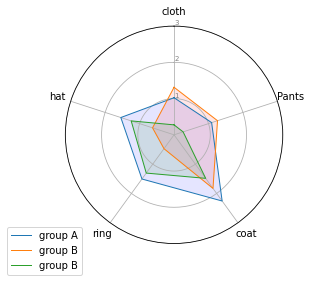

In [20]:
# ------- PART 1: Create background
 
# number of variable
categories=list(df)[1:]
category_num = df.shape[1] - 1
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(category_num) * 2 * math.pi for n in range(category_num)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(math.pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([1,2,3], ["1","2","3"], color="grey", size=7)
plt.ylim(0,int(max(person_category_scores)) +1)

# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
# I don't make a loop, because plotting more than 3 groups makes the chart unreadable
 
# Ind1
values=df.loc[0].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="group A")
ax.fill(angles, values, 'b', alpha=0.1)
 
# Ind2
values=df.loc[1].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="group B")
ax.fill(angles, values, 'r', alpha=0.1)
 
# Ind2
values=df.loc[2].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="group B")
ax.fill(angles, values, 'g', alpha=0.1)
 
# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Show the graph
plt.show()